# LUNG CANCER DETECTION 

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy,categorical_crossentropy, top_k_categorical_accuracy
from keras import backend as k
from keras.layers.convolutional import*
import os
import tensorflow as tf
import random as rn
from matplotlib import pyplot as plt
import itertools
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam,RMSprop
%matplotlib inline
import json

Using TensorFlow backend.


In [2]:
tf.keras.backend.clear_session()

In [3]:
#CREATING VARIABLES AND ASSIGNING PATH
train_path='D:/Sahana/Pre-processing/dicomimages/train'
valid_path='D:/Sahana/Pre-processing/dicomimages/valid'
test_path='D:/Sahana/Pre-processing/dicomimages/test'

In [4]:
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['0','1'],batch_size=10)
valid_batches=ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['00','11'],batch_size=10)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['test1'],batch_size=1)

Found 1660 images belonging to 2 classes.
Found 314 images belonging to 2 classes.
Found 2 images belonging to 1 classes.


In [31]:
#FUNCTION TO DISPLAY THE IMAGES
#plot image with labels
def plots(ims,figsize=(12,6),rows=1,interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ims=np.array(ims).astype(np.uint8)
        if(ims.shape[-1]!=3):
            ims=ims.transpose((0,2,3,1))
    f=plt.figure(figsize=figsize)
    cols=len(ims)//rows if len(ims) %2==0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp=f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i],cmap="CMRmap",interpolation=None if interp else 'none')

In [32]:
imgs,labels=next(train_batches)

FEW IMAGES OF TRAINING DATASET


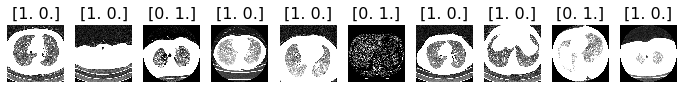

In [34]:
#we call the function plot to display images
print("FEW IMAGES OF TRAINING DATASET")
plots(imgs, titles=labels)

FEW IMAGES OF VALID DATASET


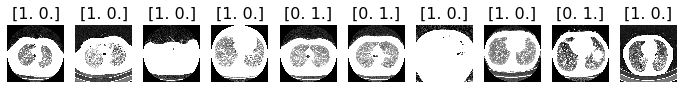

In [35]:
imgs1,labels1=next(valid_batches)
print("FEW IMAGES OF VALID DATASET")
plots(imgs1, titles=labels1)

In [36]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [37]:
time_callback = TimeHistory()

In [38]:
import json
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

In [39]:
from tensorflow.keras.applications.vgg16 import VGG16

In [40]:
from tensorflow.keras import layers 

In [41]:
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [42]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
for layer in base_model.layers:
    layer.trainable = False

In [44]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='softmax')(x)



In [45]:
model = tf.keras.models.Model(base_model.input, x)

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [47]:
model.compile(tf.keras.optimizers.Adam(lr=.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [48]:
tf.keras.backend.clear_session()

In [49]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=2,
                                  verbose=1,factor=0.2)

filepath="VGG16_NoSegment_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history= model.fit(train_batches, steps_per_epoch=166,
                              validation_data=valid_batches,validation_steps=31,epochs=20,verbose=1,
                              callbacks=[learn_control, checkpoint,time_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 166 steps, validate for 31 steps
Epoch 1/20
165/166 [============================>.] - ETA: 0s - loss: 2.6962 - accuracy: 0.8036
Epoch 00001: val_accuracy improved from -inf to 0.82581, saving model to VGG16_NoSegment_weights_best.hdf5
166/166 [==============================] - 27s 166ms/step - loss: 2.6800 - accuracy: 0.8048 - val_loss: 2.4204 - val_accuracy: 0.8258
Epoch 2/20
165/166 [============================>.] - ETA: 0s - loss: 0.3950 - accuracy: 0.9679
Epoch 00002: val_accuracy did not improve from 0.82581
166/166 [==============================] - 25s 153ms/step - loss: 0.3927 - accuracy: 0.9681 - val_loss: 2.5580 - val_accuracy: 0.8226
Epoch 3/20
165/166 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.9715
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 00003: val_accuracy did not improve from 0.82581
166/166 [==============================] - 26s 154ms

In [50]:
sum(time_callback.times)

517.549322605133

In [5]:
from tensorflow.keras.models import load_model

In [6]:
model=load_model('VGG16_NoSegment_weights_best.hdf5')

In [4]:
import pandas as pd

In [7]:
results = model.evaluate(train_batches)
print("Training set of Images")
print('loss, accuracy', results)

  ...
    to  
  ['...']
166/166 [==============================] - 28s 166ms/step - loss: 0.3075 - accuracy: 0.9771
Training set of Images
loss, accuracy [0.30749886528035103, 0.9771084]


In [9]:
results1 = model.evaluate(valid_batches)
print("Validating set of Images")
print('loss, accuracy', results1)

  ...
    to  
  ['...']
32/32 [==============================] - 7s 206ms/step - loss: 2.5125 - accuracy: 0.8217
Validating set of Images
loss, accuracy [2.5125414493807057, 0.82165605]


# LOADING AND TESTING MODEL

In [10]:
test_path="D:/Sahana/New_Segment/test"

In [23]:
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['test1'],batch_size=1)

Found 1 images belonging to 1 classes.


1/1 - 0s


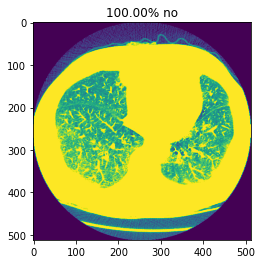

In [24]:
import matplotlib.image as mpimg
# Predicting

probabilities =model.predict(test_batches, steps=1,verbose=2)
for index, probability in enumerate(probabilities):
    image_path = test_path + "/" +test_batches.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability[0] > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% no")
    
    else:
        plt.title("%.2f" % ((probability[1])*100) + "% yes")
    plt.show()